In [130]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [131]:
L = 7 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=3
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [132]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
        0.         |2 2 2 2 2 2 2>           2186  
        1.         |2 2 2 2 2 2 1>           2185  
        2.         |2 2 2 2 2 2 0>           2184  
        3.         |2 2 2 2 2 1 2>           2183  
        4.         |2 2 2 2 2 1 1>           2182  
        5.         |2 2 2 2 2 1 0>           2181  
        6.         |2 2 2 2 2 0 2>           2180  
        7.         |2 2 2 2 2 0 1>           2179  
        8.         |2 2 2 2 2 0 0>           2178  
        9.         |2 2 2 2 1 2 2>           2177  
       10.         |2 2 2 2 1 2 1>           2176  
       11.         |2 2 2 2 1 2 0>           2175  
       12.         |2 2 2 2 1 1 2>           2174  
       13.         |2 2 2 2 1 1 1>           2173  
       14.         |2 2 2 2 1 1 0>           2172  
       15.         |2 2 2 2 1 0 2>           2171  
       16.         |2 2 2 2 1 0 1>           2170  
       17.         |2 2 2 2 1 0 0>           21

In [133]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [134]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [135]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [136]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [137]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [138]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [139]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [140]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [141]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [142]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-1.43920377 -0.43399733 -0.32159336]


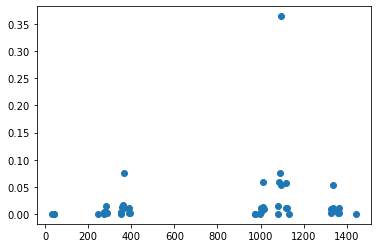

In [143]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvec[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")


In [144]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [145]:
def swap(m,n):
    swap_matrix = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    swap_matrix = sparse.csc_matrix(swap_matrix)
    for i in range(basis.Ns):
        state_m = basis.int_to_state(basis.Ns-i-1)[2*m+1]
        state_n = basis.int_to_state(basis.Ns-i-1)[2*n+1]
        string = list(basis.int_to_state(basis.Ns-i-1))
        string[2*m+1],string[2*n+1] = state_n,state_m
        string = "".join(string)
        string = string.replace(" ", "")
        string = string.replace("|","")
        string = string.replace(">", "")
        i_new = basis.Ns-1-basis.state_to_int(string)
        swap_matrix[i_new,i] = 1.
        
    return swap_matrix


def exp_gate(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = np.cos(theta/2)
    Matrix[8-1,8-1] = np.cos(theta/2)
    Matrix[8-2,8-2] = 0

    Matrix[8-3,8-3] = np.cos(theta/2)
    Matrix[8-4,8-4] = np.cos(theta/2)
    Matrix[8-5,8-5] = 0

    Matrix[8-6,8-6] = -np.cos(theta/2)
    Matrix[8-7,8-7] = np.cos(theta/2)
    Matrix[8-8,8-8] = -1j

    Matrix[8-0,8-4] = -1j*np.sin(theta/2)
    Matrix[8-4,8-0] = -1j*np.sin(theta/2)

    Matrix[8-1,8-3] = -1j*np.sin(theta/2)
    Matrix[8-3,8-1] = -1j*np.sin(theta/2)


    Matrix[8-5,8-2] = -1
    Matrix[8-2,8-5] = -1

    Matrix[8-6,8-7] = np.sin(theta/2)
    Matrix[8-7,8-6] = np.sin(theta/2)

    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full

In [146]:
def exp_gate_der(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = -np.sin(theta/2)/2
    Matrix[8-1,8-1] = -np.sin(theta/2)/2

    Matrix[8-3,8-3] = -np.sin(theta/2)/2
    Matrix[8-4,8-4] = -np.sin(theta/2)/2

    Matrix[8-6,8-6] = np.sin(theta/2)/2
    Matrix[8-7,8-7] = -np.sin(theta/2)/2

    Matrix[8-0,8-4] = -1j*np.cos(theta/2)/2
    Matrix[8-4,8-0] = -1j*np.cos(theta/2)/2

    Matrix[8-1,8-3] = -1j*np.cos(theta/2)/2
    Matrix[8-3,8-1] = -1j*np.cos(theta/2)/2



    Matrix[8-6,8-7] = np.cos(theta/2)/2
    Matrix[8-7,8-6] = np.cos(theta/2)/2
    
    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full




In [147]:
%time exp_gate_der(0,np.pi/3)

CPU times: user 3.62 ms, sys: 0 ns, total: 3.62 ms
Wall time: 2.85 ms


<2187x2187 sparse matrix of type '<class 'numpy.complex128'>'
	with 2916 stored elements in COOrdinate format>

In [148]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [149]:
def R(i,theta):
    
    if i%15 == 0:
        return(exp_gate(0,theta))

    if i%15 == 1:
        return(exp_gate(1,theta))

    if i%15 == 2:
        return(exp_gate(2,theta))

    if i%15 == 3:
        return(exp_gate(3,theta))
    
    if i%15 == 4:
        return(exp_gate(4,theta))

    if i%15 == 5:
        return(exp_gate(5,theta))

    if i%15 == 6:
        return(rot_sigma_e(0,1,0,theta))


    if i%15 == 7:
        return(rot_sigma_e(0,2,0,theta))

    
    if i%15 == 8:
        return(rot_sigma_e(1,2,np.pi/2,theta))

    
    if i%15 == 9:
        return(rot_sigma_o(0,1,0,theta))


    if i%15 == 10:
        return(rot_sigma_o(0,2,0,theta))

    
    if i%15 == 11:
        return(rot_sigma_o(1,2,np.pi/2,theta))

    if i%15 == 12:
        return(rot_sigma_r(0,1,0,theta))


    if i%15 == 13:
        return(rot_sigma_r(0,2,0,theta))

    
    if i%15 == 14:
        return(rot_sigma_r(1,2,np.pi/2,theta))
        

def S(i,theta):
    
    if i%15 == 0:
        return(exp_gate_der(0,theta)@exp_gate(0,theta).T.conj())

    if i%15 == 1:
        return(exp_gate_der(1,theta)@exp_gate(1,theta).T.conj())
    
    if i%15 == 2:
        return(exp_gate_der(2,theta)@exp_gate(2,theta).T.conj())

    if i%15 == 3:
        return(exp_gate_der(3,theta)@exp_gate(3,theta).T.conj())
    
    if i%15 == 4:
        return(exp_gate_der(4,theta)@exp_gate(4,theta).T.conj())

    if i%15 == 5:
        return(exp_gate_der(5,theta)@exp_gate(5,theta).T.conj())

    if i%15 == 6:
        return(-1j*sigma_e(0,1,0))

    
    if i%15 == 7:
        return(-1j*sigma_e(0,2,0))

    
    if i%15 == 8:
        return(-1j*sigma_e(1,2,np.pi/2))
     
    if i%15 == 9:
        return(-1j*sigma_o(0,1,0))

    
    if i%15 == 10:
        return(-1j*sigma_o(0,2,0))

    
    if i%15 == 11:
        return(-1j*sigma_o(1,2,np.pi/2))

     
    if i%15 == 12:
        return(-1j*sigma_r(0,1,0))

    
    if i%15 == 13:
        return(-1j*sigma_r(0,2,0))
    

    if i%15 == 14:
        return(-1j*sigma_r(1,2,np.pi/2))

In [150]:
coeff = 15
stepp = 800
t_final = 80

In [151]:
expt_value = []
energyy = []

time_domain = np.linspace(0, t_final, stepp)

Y = []

In [152]:
for kkk in range(1):
    
    N=3
    start_point = np.random.rand(coeff*N)

    matr = full_ham_matrix.toarray()
    B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
    psi_d = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s2 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]

    def rhs(t,theta):

        print(datetime.datetime.now())
        for k in range(coeff*N):
            B[k] = R(k,theta[k])

        psi_b = psi_0
        for k in range(coeff*N):
            psi_b = B[coeff*N-1-k]@psi_b
        for i in range(L+1):
            psi_b = (Proj[i]+Proj_0[i])@psi_b
        norm_b = np.sqrt(np.real(np.conj(psi_b)@psi_b))
        psi_b = psi_b/norm_b



        psi_conj_b = np.conj(psi_b)

        print("start",datetime.datetime.now())

        for k in range(coeff*N):
            B[k] = S(k,theta[k])@R(k,theta[k])
            psi_d[k] = psi_0
            for i in range(coeff*N):
                psi_d[k] = B[coeff*N-1-i]@psi_d[k]
            B[k] = R(k,theta[k])

        print("stop_reduce",datetime.datetime.now())

        psi_conj_d = np.conj(psi_d)


        for k in range(coeff*N):
            for i in range(L+1):
                psi_d_1[k] = (Proj[i]+Proj_0[i])@psi_d[k]  
            psi_d_s1[k] = psi_d_1[k]/norm_b
            psi_d_s2[k] = -psi_b*(psi_conj_d[k]@psi_b+psi_conj_b@psi_d[k])
            psi_d[k] = psi_d_s1[k]+psi_d_s2[k]

        psi_conj_d = np.conj(psi_d)




        X = np.zeros((coeff*N,coeff*N),dtype = complex)
        Y = np.zeros(coeff*N,dtype = complex)


        X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

        Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)

        XX = np.einsum("il,l->i",psi_conj_d,psi_b)

        YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)

        YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
        YY = YY_1*YY_2
        XX = np.outer(XX,XX)
        X_r = 2*np.real(X+XX)
        Y_i = 2*np.real(Y+YY)
        result = -np.linalg.pinv(X_r,rcond = 1e-10)@Y_i
        print(datetime.datetime.now())

        print(t)

        return result

    # RK-4 method
    def rk4(x0,y0,xn,n):
        global Y

        # Calculating step size
        h = (xn-x0)/n

        #print('\n--------SOLUTION--------')
        #print('-------------------------')    
        #print('x0\ty0\tyn')
        #print('-------------------------')
        for i in range(n):
            k1 = h * (rhs(x0, y0))
            k2 = h * (rhs((x0+h/2), (y0+k1/2)))
            k3 = h * (rhs((x0+h/2), (y0+k2/2)))
            k4 = h * (rhs((x0+h), (y0+k3)))
            k = (k1+2*k2+2*k3+k4)/6
            yn = y0 + k
            #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
            #print('-------------------------')
            y0 = yn
            x0 = x0+h
            Y.append(y0)

        #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

    # Inputs
    #print('Enter initial conditions:')
    #x0 = float(input('x0 = '))
    #y0 = float(input('y0 = '))

    #print('Enter calculation point: ')
    #xn = float(input('xn = '))

    #print('Enter number of steps:')
    #step = int(input('Number of steps = '))

    # RK4 method call
    #start_point = 0.001*np.ones(coeff*N)




    Y = []
    #start_point = np.zeros(coeff*N)

    rk4(0,start_point,t_final,stepp)
    def var_ansatz(theta,psi_0):
        psi = psi_0
        for i in range(coeff*N):
            psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

        return psi
    psi = var_ansatz(start_point,psi_0)
    psi_ground = eigenvec[:,0]
    expt_value_u = np.zeros(len(time_domain))
    energy = np.zeros(len(time_domain))

    psi = var_ansatz(start_point,psi_0)
    for tt in range(len(time_domain)):
        theta = []
        for i in range(coeff*N):
            theta.append(Y[tt][i])


        psi_var = var_ansatz(theta,psi_0)
        for i in range(L+1):
            psi_var = (Proj[i]+Proj_0[i])@psi_var
        norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

        expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
        energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)
        
    expt_value.append(expt_value_u)
    energyy.append(energy)


    

2022-08-16 13:01:10.209077
start 2022-08-16 13:01:10.475294
stop_reduce 2022-08-16 13:01:12.055847
2022-08-16 13:01:12.716479
0
2022-08-16 13:01:12.717197
start 2022-08-16 13:01:13.015158
stop_reduce 2022-08-16 13:01:14.566445
2022-08-16 13:01:15.170401
0.05
2022-08-16 13:01:15.170511
start 2022-08-16 13:01:15.450965
stop_reduce 2022-08-16 13:01:16.934950
2022-08-16 13:01:17.524003
0.05
2022-08-16 13:01:17.524131
start 2022-08-16 13:01:17.844203
stop_reduce 2022-08-16 13:01:19.479606
2022-08-16 13:01:20.117625
0.1
2022-08-16 13:01:20.117713
start 2022-08-16 13:01:20.412637
stop_reduce 2022-08-16 13:01:21.959037
2022-08-16 13:01:22.586650
0.1
2022-08-16 13:01:22.587332
start 2022-08-16 13:01:22.873854
stop_reduce 2022-08-16 13:01:24.362901
2022-08-16 13:01:24.974056
0.15000000000000002
2022-08-16 13:01:24.974679
start 2022-08-16 13:01:25.261242
stop_reduce 2022-08-16 13:01:26.822240
2022-08-16 13:01:27.416965
0.15000000000000002
2022-08-16 13:01:27.417095
start 2022-08-16 13:01:27.70176

stop_reduce 2022-08-16 13:03:40.244230
2022-08-16 13:03:40.857603
1.5000000000000002
2022-08-16 13:03:40.857685
start 2022-08-16 13:03:41.137237
stop_reduce 2022-08-16 13:03:42.730311
2022-08-16 13:03:43.346636
1.5500000000000003
2022-08-16 13:03:43.346720
start 2022-08-16 13:03:43.636639
stop_reduce 2022-08-16 13:03:45.222737
2022-08-16 13:03:45.839439
1.5500000000000003
2022-08-16 13:03:45.839555
start 2022-08-16 13:03:46.120438
stop_reduce 2022-08-16 13:03:47.710949
2022-08-16 13:03:48.327063
1.6000000000000003
2022-08-16 13:03:48.327159
start 2022-08-16 13:03:48.608850
stop_reduce 2022-08-16 13:03:50.195350
2022-08-16 13:03:50.809145
1.6000000000000003
2022-08-16 13:03:50.809253
start 2022-08-16 13:03:51.090799
stop_reduce 2022-08-16 13:03:52.677650
2022-08-16 13:03:53.291807
1.6500000000000004
2022-08-16 13:03:53.291919
start 2022-08-16 13:03:53.573735
stop_reduce 2022-08-16 13:03:55.156679
2022-08-16 13:03:55.770028
1.6500000000000004
2022-08-16 13:03:55.770107
start 2022-08-16 1

start 2022-08-16 13:06:02.692740
stop_reduce 2022-08-16 13:06:04.305244
2022-08-16 13:06:04.925921
2.950000000000001
2022-08-16 13:06:04.926049
start 2022-08-16 13:06:05.225223
stop_reduce 2022-08-16 13:06:06.814371
2022-08-16 13:06:07.428491
2.950000000000001
2022-08-16 13:06:07.428596
start 2022-08-16 13:06:07.710417
stop_reduce 2022-08-16 13:06:09.299501
2022-08-16 13:06:09.913905
3.0000000000000013
2022-08-16 13:06:09.914032
start 2022-08-16 13:06:10.196037
stop_reduce 2022-08-16 13:06:11.793255
2022-08-16 13:06:12.408193
3.0000000000000013
2022-08-16 13:06:12.408299
start 2022-08-16 13:06:12.696957
stop_reduce 2022-08-16 13:06:14.494125
2022-08-16 13:06:15.212692
3.050000000000001
2022-08-16 13:06:15.212816
start 2022-08-16 13:06:15.522544
stop_reduce 2022-08-16 13:06:17.340736
2022-08-16 13:06:18.097100
3.050000000000001
2022-08-16 13:06:18.097659
start 2022-08-16 13:06:18.414730
stop_reduce 2022-08-16 13:06:20.183575
2022-08-16 13:06:20.854071
3.1000000000000014
2022-08-16 13:06

start 2022-08-16 13:08:36.299937
stop_reduce 2022-08-16 13:08:38.019491
2022-08-16 13:08:38.670592
4.3500000000000005
2022-08-16 13:08:38.670678
start 2022-08-16 13:08:38.955557
stop_reduce 2022-08-16 13:08:40.556290
2022-08-16 13:08:41.172110
4.4
2022-08-16 13:08:41.172231
start 2022-08-16 13:08:41.473633
stop_reduce 2022-08-16 13:08:43.120784
2022-08-16 13:08:43.743692
4.4
2022-08-16 13:08:43.743794
start 2022-08-16 13:08:44.058091
stop_reduce 2022-08-16 13:08:45.833519
2022-08-16 13:08:46.525100
4.45
2022-08-16 13:08:46.525210
start 2022-08-16 13:08:46.838265
stop_reduce 2022-08-16 13:08:48.640346
2022-08-16 13:08:49.384072
4.45
2022-08-16 13:08:49.384188
start 2022-08-16 13:08:49.678262
stop_reduce 2022-08-16 13:08:51.400248
2022-08-16 13:08:52.092375
4.5
2022-08-16 13:08:52.092609
start 2022-08-16 13:08:52.416703
stop_reduce 2022-08-16 13:08:54.139232
2022-08-16 13:08:54.804383
4.5
2022-08-16 13:08:54.804507
start 2022-08-16 13:08:55.096388
stop_reduce 2022-08-16 13:08:56.775659
2

start 2022-08-16 13:11:19.766271
stop_reduce 2022-08-16 13:11:21.558139
2022-08-16 13:11:22.222227
5.799999999999995
2022-08-16 13:11:22.222315
start 2022-08-16 13:11:22.525596
stop_reduce 2022-08-16 13:11:24.277573
2022-08-16 13:11:24.982497
5.849999999999995
2022-08-16 13:11:24.982600
start 2022-08-16 13:11:25.304551
stop_reduce 2022-08-16 13:11:27.069440
2022-08-16 13:11:27.759509
5.849999999999995
2022-08-16 13:11:27.759774
start 2022-08-16 13:11:28.074801
stop_reduce 2022-08-16 13:11:29.954826
2022-08-16 13:11:30.705135
5.899999999999995
2022-08-16 13:11:30.705430
start 2022-08-16 13:11:31.058761
stop_reduce 2022-08-16 13:11:33.000774
2022-08-16 13:11:33.758274
5.899999999999995
2022-08-16 13:11:33.758536
start 2022-08-16 13:11:34.110830
stop_reduce 2022-08-16 13:11:36.016397
2022-08-16 13:11:36.757367
5.949999999999995
2022-08-16 13:11:36.757466
start 2022-08-16 13:11:37.083843
stop_reduce 2022-08-16 13:11:38.915931
2022-08-16 13:11:39.616728
5.949999999999995
2022-08-16 13:11:39

start 2022-08-16 13:14:04.633338
stop_reduce 2022-08-16 13:14:06.295463
2022-08-16 13:14:06.932480
7.24999999999999
2022-08-16 13:14:06.932563
start 2022-08-16 13:14:07.221245
stop_reduce 2022-08-16 13:14:08.866421
2022-08-16 13:14:09.506416
7.24999999999999
2022-08-16 13:14:09.506497
start 2022-08-16 13:14:09.804184
stop_reduce 2022-08-16 13:14:11.576401
2022-08-16 13:14:12.244055
7.29999999999999
2022-08-16 13:14:12.244173
start 2022-08-16 13:14:12.593233
stop_reduce 2022-08-16 13:14:14.688189
2022-08-16 13:14:15.371215
7.29999999999999
2022-08-16 13:14:15.371624
start 2022-08-16 13:14:15.709612
stop_reduce 2022-08-16 13:14:17.760155
2022-08-16 13:14:18.736178
7.34999999999999
2022-08-16 13:14:18.736306
start 2022-08-16 13:14:19.182182
stop_reduce 2022-08-16 13:14:21.345063
2022-08-16 13:14:22.047952
7.34999999999999
2022-08-16 13:14:22.048074
start 2022-08-16 13:14:22.355374
stop_reduce 2022-08-16 13:14:24.231003
2022-08-16 13:14:24.973714
7.39999999999999
2022-08-16 13:14:24.974051

start 2022-08-16 13:16:48.153620
stop_reduce 2022-08-16 13:16:49.813635
2022-08-16 13:16:50.455987
8.649999999999986
2022-08-16 13:16:50.456071
start 2022-08-16 13:16:50.748694
stop_reduce 2022-08-16 13:16:52.413060
2022-08-16 13:16:53.065884
8.699999999999985
2022-08-16 13:16:53.066264
start 2022-08-16 13:16:53.359913
stop_reduce 2022-08-16 13:16:55.015114
2022-08-16 13:16:55.660244
8.699999999999985
2022-08-16 13:16:55.660329
start 2022-08-16 13:16:55.956374
stop_reduce 2022-08-16 13:16:57.619915
2022-08-16 13:16:58.272946
8.749999999999986
2022-08-16 13:16:58.273060
start 2022-08-16 13:16:58.569320
stop_reduce 2022-08-16 13:17:00.250727
2022-08-16 13:17:00.903335
8.749999999999986
2022-08-16 13:17:00.903720
start 2022-08-16 13:17:01.199100
stop_reduce 2022-08-16 13:17:02.861197
2022-08-16 13:17:03.508336
8.799999999999985
2022-08-16 13:17:03.508423
start 2022-08-16 13:17:03.800468
stop_reduce 2022-08-16 13:17:05.529727
2022-08-16 13:17:06.219255
8.799999999999985
2022-08-16 13:17:06

start 2022-08-16 13:19:17.861078
stop_reduce 2022-08-16 13:19:19.486196
2022-08-16 13:19:20.119758
10.09999999999998
2022-08-16 13:19:20.119866
start 2022-08-16 13:19:20.410639
stop_reduce 2022-08-16 13:19:22.047573
2022-08-16 13:19:22.696798
10.09999999999998
2022-08-16 13:19:22.696907
start 2022-08-16 13:19:22.987618
stop_reduce 2022-08-16 13:19:24.613971
2022-08-16 13:19:25.248163
10.14999999999998
2022-08-16 13:19:25.248484
start 2022-08-16 13:19:25.542006
stop_reduce 2022-08-16 13:19:27.170383
2022-08-16 13:19:27.806689
10.14999999999998
2022-08-16 13:19:27.806771
start 2022-08-16 13:19:28.124721
stop_reduce 2022-08-16 13:19:30.141100
2022-08-16 13:19:30.897443
10.19999999999998
2022-08-16 13:19:30.897561
start 2022-08-16 13:19:31.241186
stop_reduce 2022-08-16 13:19:32.985300
2022-08-16 13:19:33.671091
10.19999999999998
2022-08-16 13:19:33.671172
start 2022-08-16 13:19:33.981074
stop_reduce 2022-08-16 13:19:35.790977
2022-08-16 13:19:36.568442
10.24999999999998
2022-08-16 13:19:36

start 2022-08-16 13:21:49.042400
stop_reduce 2022-08-16 13:21:50.726357
2022-08-16 13:21:51.463296
11.499999999999975
2022-08-16 13:21:51.463613
start 2022-08-16 13:21:51.817813
stop_reduce 2022-08-16 13:21:53.541196
2022-08-16 13:21:54.224236
11.549999999999976
2022-08-16 13:21:54.224347
start 2022-08-16 13:21:54.527447
stop_reduce 2022-08-16 13:21:56.177891
2022-08-16 13:21:56.854482
11.549999999999976
2022-08-16 13:21:56.854591
start 2022-08-16 13:21:57.211349
stop_reduce 2022-08-16 13:21:59.162754
2022-08-16 13:21:59.941625
11.599999999999975
2022-08-16 13:21:59.942103
start 2022-08-16 13:22:00.315201
stop_reduce 2022-08-16 13:22:02.181278
2022-08-16 13:22:02.826251
11.599999999999975
2022-08-16 13:22:02.826361
start 2022-08-16 13:22:03.121953
stop_reduce 2022-08-16 13:22:05.072601
2022-08-16 13:22:05.859118
11.649999999999975
2022-08-16 13:22:05.859237
start 2022-08-16 13:22:06.227312
stop_reduce 2022-08-16 13:22:08.139285
2022-08-16 13:22:08.883412
11.649999999999975
2022-08-16 1

start 2022-08-16 13:24:20.415793
stop_reduce 2022-08-16 13:24:22.057755
2022-08-16 13:24:22.689123
12.94999999999997
2022-08-16 13:24:22.689222
start 2022-08-16 13:24:22.977966
stop_reduce 2022-08-16 13:24:24.606140
2022-08-16 13:24:25.241035
12.94999999999997
2022-08-16 13:24:25.241285
start 2022-08-16 13:24:25.528990
stop_reduce 2022-08-16 13:24:27.150500
2022-08-16 13:24:27.785519
12.99999999999997
2022-08-16 13:24:27.785632
start 2022-08-16 13:24:28.076235
stop_reduce 2022-08-16 13:24:29.698991
2022-08-16 13:24:30.333924
12.99999999999997
2022-08-16 13:24:30.334022
start 2022-08-16 13:24:30.625271
stop_reduce 2022-08-16 13:24:32.463816
2022-08-16 13:24:33.161464
13.04999999999997
2022-08-16 13:24:33.161574
start 2022-08-16 13:24:33.477154
stop_reduce 2022-08-16 13:24:35.200945
2022-08-16 13:24:35.879334
13.04999999999997
2022-08-16 13:24:35.879801
start 2022-08-16 13:24:36.199545
stop_reduce 2022-08-16 13:24:38.018948
2022-08-16 13:24:38.847015
13.09999999999997
2022-08-16 13:24:38

start 2022-08-16 13:26:48.813550
stop_reduce 2022-08-16 13:26:50.454054
2022-08-16 13:26:51.095668
14.349999999999966
2022-08-16 13:26:51.095751
start 2022-08-16 13:26:51.386996
stop_reduce 2022-08-16 13:26:53.029681
2022-08-16 13:26:53.670140
14.399999999999965
2022-08-16 13:26:53.670550
start 2022-08-16 13:26:53.963022
stop_reduce 2022-08-16 13:26:55.608544
2022-08-16 13:26:56.251483
14.399999999999965
2022-08-16 13:26:56.251568
start 2022-08-16 13:26:56.543458
stop_reduce 2022-08-16 13:26:58.179220
2022-08-16 13:26:58.817365
14.449999999999966
2022-08-16 13:26:58.817472
start 2022-08-16 13:26:59.108313
stop_reduce 2022-08-16 13:27:00.749672
2022-08-16 13:27:01.389026
14.449999999999966
2022-08-16 13:27:01.389128
start 2022-08-16 13:27:01.680937
stop_reduce 2022-08-16 13:27:03.263261
2022-08-16 13:27:03.872759
14.499999999999964
2022-08-16 13:27:03.872875
start 2022-08-16 13:27:04.153603
stop_reduce 2022-08-16 13:27:05.786778
2022-08-16 13:27:06.397739
14.499999999999964
2022-08-16 1

start 2022-08-16 13:29:11.754084
stop_reduce 2022-08-16 13:29:13.303507
2022-08-16 13:29:13.914349
15.79999999999996
2022-08-16 13:29:13.914443
start 2022-08-16 13:29:14.195468
stop_reduce 2022-08-16 13:29:15.748602
2022-08-16 13:29:16.358842
15.79999999999996
2022-08-16 13:29:16.358943
start 2022-08-16 13:29:16.640610
stop_reduce 2022-08-16 13:29:18.246319
2022-08-16 13:29:18.887950
15.84999999999996
2022-08-16 13:29:18.888081
start 2022-08-16 13:29:19.181191
stop_reduce 2022-08-16 13:29:20.824677
2022-08-16 13:29:21.469843
15.84999999999996
2022-08-16 13:29:21.470071
start 2022-08-16 13:29:21.766893
stop_reduce 2022-08-16 13:29:23.415082
2022-08-16 13:29:24.059116
15.89999999999996
2022-08-16 13:29:24.059215
start 2022-08-16 13:29:24.351402
stop_reduce 2022-08-16 13:29:25.996823
2022-08-16 13:29:26.610565
15.89999999999996
2022-08-16 13:29:26.610647
start 2022-08-16 13:29:26.890264
stop_reduce 2022-08-16 13:29:28.455154
2022-08-16 13:29:29.101031
15.94999999999996
2022-08-16 13:29:29

start 2022-08-16 13:31:38.786165
stop_reduce 2022-08-16 13:31:40.617041
2022-08-16 13:31:41.344684
17.199999999999974
2022-08-16 13:31:41.344770
start 2022-08-16 13:31:41.694881
stop_reduce 2022-08-16 13:31:43.549574
2022-08-16 13:31:44.390803
17.249999999999975
2022-08-16 13:31:44.391707
start 2022-08-16 13:31:44.707465
stop_reduce 2022-08-16 13:31:46.717855
2022-08-16 13:31:47.632018
17.249999999999975
2022-08-16 13:31:47.632140
start 2022-08-16 13:31:48.107429
stop_reduce 2022-08-16 13:31:50.183758
2022-08-16 13:31:50.998992
17.299999999999976
2022-08-16 13:31:50.999121
start 2022-08-16 13:31:51.320817
stop_reduce 2022-08-16 13:31:53.260534
2022-08-16 13:31:54.080828
17.299999999999976
2022-08-16 13:31:54.080943
start 2022-08-16 13:31:54.441426
stop_reduce 2022-08-16 13:31:56.602609
2022-08-16 13:31:57.421151
17.349999999999977
2022-08-16 13:31:57.421291
start 2022-08-16 13:31:57.781864
stop_reduce 2022-08-16 13:31:59.794215
2022-08-16 13:32:00.567758
17.349999999999977
2022-08-16 1

start 2022-08-16 13:34:20.473001
stop_reduce 2022-08-16 13:34:22.123931
2022-08-16 13:34:22.765281
18.649999999999995
2022-08-16 13:34:22.765405
start 2022-08-16 13:34:23.061284
stop_reduce 2022-08-16 13:34:24.702273
2022-08-16 13:34:25.345582
18.649999999999995
2022-08-16 13:34:25.345921
start 2022-08-16 13:34:25.639200
stop_reduce 2022-08-16 13:34:27.298351
2022-08-16 13:34:27.942271
18.699999999999996
2022-08-16 13:34:27.942392
start 2022-08-16 13:34:28.235397
stop_reduce 2022-08-16 13:34:29.888814
2022-08-16 13:34:30.536072
18.699999999999996
2022-08-16 13:34:30.536179
start 2022-08-16 13:34:30.825557
stop_reduce 2022-08-16 13:34:32.480120
2022-08-16 13:34:33.127956
18.749999999999996
2022-08-16 13:34:33.128067
start 2022-08-16 13:34:33.419359
stop_reduce 2022-08-16 13:34:35.064700
2022-08-16 13:34:35.710058
18.749999999999996
2022-08-16 13:34:35.710136
start 2022-08-16 13:34:36.002604
stop_reduce 2022-08-16 13:34:37.643489
2022-08-16 13:34:38.284857
18.799999999999997
2022-08-16 1

start 2022-08-16 13:36:54.164382
stop_reduce 2022-08-16 13:36:55.944290
2022-08-16 13:36:56.611515
20.100000000000016
2022-08-16 13:36:56.611650
start 2022-08-16 13:36:56.917207
stop_reduce 2022-08-16 13:36:58.947399
2022-08-16 13:36:59.663440
20.100000000000016
2022-08-16 13:36:59.663566
start 2022-08-16 13:36:59.978381
stop_reduce 2022-08-16 13:37:01.860570
2022-08-16 13:37:02.626359
20.150000000000016
2022-08-16 13:37:02.626482
start 2022-08-16 13:37:02.971496
stop_reduce 2022-08-16 13:37:04.926672
2022-08-16 13:37:05.796956
20.150000000000016
2022-08-16 13:37:05.797055
start 2022-08-16 13:37:06.207523
stop_reduce 2022-08-16 13:37:08.172699
2022-08-16 13:37:08.853427
20.200000000000017
2022-08-16 13:37:08.853563
start 2022-08-16 13:37:09.176983
stop_reduce 2022-08-16 13:37:10.986547
2022-08-16 13:37:11.685073
20.200000000000017
2022-08-16 13:37:11.685165
start 2022-08-16 13:37:12.067266
stop_reduce 2022-08-16 13:37:14.097440
2022-08-16 13:37:14.821038
20.250000000000018
2022-08-16 1

start 2022-08-16 13:39:38.243704
stop_reduce 2022-08-16 13:39:39.990179
2022-08-16 13:39:40.647183
21.500000000000036
2022-08-16 13:39:40.647304
start 2022-08-16 13:39:40.954226
stop_reduce 2022-08-16 13:39:42.690944
2022-08-16 13:39:43.369407
21.550000000000036
2022-08-16 13:39:43.369493
start 2022-08-16 13:39:43.676578
stop_reduce 2022-08-16 13:39:45.426931
2022-08-16 13:39:46.132369
21.550000000000036
2022-08-16 13:39:46.132483
start 2022-08-16 13:39:46.479013
stop_reduce 2022-08-16 13:39:48.360113
2022-08-16 13:39:49.051613
21.600000000000037
2022-08-16 13:39:49.051711
start 2022-08-16 13:39:49.360149
stop_reduce 2022-08-16 13:39:51.585904
2022-08-16 13:39:52.334187
21.600000000000037
2022-08-16 13:39:52.334296
start 2022-08-16 13:39:52.713824
stop_reduce 2022-08-16 13:39:54.539909
2022-08-16 13:39:55.234950
21.650000000000038
2022-08-16 13:39:55.235081
start 2022-08-16 13:39:55.552317
stop_reduce 2022-08-16 13:39:57.438304
2022-08-16 13:39:58.330172
21.650000000000038
2022-08-16 1

start 2022-08-16 13:42:49.123491
stop_reduce 2022-08-16 13:42:51.192817
2022-08-16 13:42:52.041538
22.950000000000056
2022-08-16 13:42:52.041650
start 2022-08-16 13:42:52.425012
stop_reduce 2022-08-16 13:42:54.588501
2022-08-16 13:42:55.380285
22.950000000000056
2022-08-16 13:42:55.380404
start 2022-08-16 13:42:55.737553
stop_reduce 2022-08-16 13:42:57.718396
2022-08-16 13:42:58.486372
23.000000000000057
2022-08-16 13:42:58.486491
start 2022-08-16 13:42:58.880763
stop_reduce 2022-08-16 13:43:00.882295
2022-08-16 13:43:01.723350
23.000000000000057
2022-08-16 13:43:01.723459
start 2022-08-16 13:43:02.108038
stop_reduce 2022-08-16 13:43:04.265130
2022-08-16 13:43:05.110976
23.050000000000058
2022-08-16 13:43:05.111097
start 2022-08-16 13:43:05.529836
stop_reduce 2022-08-16 13:43:07.755962
2022-08-16 13:43:08.609301
23.050000000000058
2022-08-16 13:43:08.609769
start 2022-08-16 13:43:09.002747
stop_reduce 2022-08-16 13:43:11.184364
2022-08-16 13:43:12.049362
23.10000000000006
2022-08-16 13

start 2022-08-16 13:46:04.412384
stop_reduce 2022-08-16 13:46:06.838806
2022-08-16 13:46:07.790191
24.350000000000076
2022-08-16 13:46:07.790297
start 2022-08-16 13:46:08.233782
stop_reduce 2022-08-16 13:46:10.828742
2022-08-16 13:46:11.703847
24.400000000000077
2022-08-16 13:46:11.703956
start 2022-08-16 13:46:12.094228
stop_reduce 2022-08-16 13:46:14.489293
2022-08-16 13:46:15.329364
24.400000000000077
2022-08-16 13:46:15.329482
start 2022-08-16 13:46:15.774756
stop_reduce 2022-08-16 13:46:18.023087
2022-08-16 13:46:18.963451
24.450000000000077
2022-08-16 13:46:18.963585
start 2022-08-16 13:46:19.386064
stop_reduce 2022-08-16 13:46:21.694824
2022-08-16 13:46:22.554507
24.450000000000077
2022-08-16 13:46:22.554634
start 2022-08-16 13:46:22.978698
stop_reduce 2022-08-16 13:46:25.210493
2022-08-16 13:46:26.122585
24.500000000000078
2022-08-16 13:46:26.122737
start 2022-08-16 13:46:26.563656
stop_reduce 2022-08-16 13:46:28.797594
2022-08-16 13:46:29.724618
24.500000000000078
2022-08-16 1

start 2022-08-16 13:49:24.368854
stop_reduce 2022-08-16 13:49:26.800948
2022-08-16 13:49:27.770307
25.800000000000097
2022-08-16 13:49:27.770444
start 2022-08-16 13:49:28.237083
stop_reduce 2022-08-16 13:49:30.696554
2022-08-16 13:49:31.639293
25.800000000000097
2022-08-16 13:49:31.639755
start 2022-08-16 13:49:32.096626
stop_reduce 2022-08-16 13:49:34.518001
2022-08-16 13:49:35.450201
25.850000000000097
2022-08-16 13:49:35.450513
start 2022-08-16 13:49:35.861289
stop_reduce 2022-08-16 13:49:37.902913
2022-08-16 13:49:38.712935
25.850000000000097
2022-08-16 13:49:38.713034
start 2022-08-16 13:49:39.078331
stop_reduce 2022-08-16 13:49:41.136308
2022-08-16 13:49:41.941046
25.900000000000098
2022-08-16 13:49:41.941163
start 2022-08-16 13:49:42.317833
stop_reduce 2022-08-16 13:49:44.404079
2022-08-16 13:49:45.214505
25.900000000000098
2022-08-16 13:49:45.214618
start 2022-08-16 13:49:45.588481
stop_reduce 2022-08-16 13:49:47.655547
2022-08-16 13:49:48.469755
25.9500000000001
2022-08-16 13:

start 2022-08-16 13:52:21.110491
stop_reduce 2022-08-16 13:52:22.819010
2022-08-16 13:52:23.460768
27.200000000000117
2022-08-16 13:52:23.460851
start 2022-08-16 13:52:23.756583
stop_reduce 2022-08-16 13:52:25.407104
2022-08-16 13:52:26.046418
27.250000000000117
2022-08-16 13:52:26.046526
start 2022-08-16 13:52:26.348546
stop_reduce 2022-08-16 13:52:28.115537
2022-08-16 13:52:28.829170
27.250000000000117
2022-08-16 13:52:28.829254
start 2022-08-16 13:52:29.128902
stop_reduce 2022-08-16 13:52:30.922536
2022-08-16 13:52:31.585257
27.300000000000118
2022-08-16 13:52:31.585528
start 2022-08-16 13:52:31.895096
stop_reduce 2022-08-16 13:52:33.606610
2022-08-16 13:52:34.251224
27.300000000000118
2022-08-16 13:52:34.251332
start 2022-08-16 13:52:34.547460
stop_reduce 2022-08-16 13:52:36.260104
2022-08-16 13:52:36.929599
27.35000000000012
2022-08-16 13:52:36.929682
start 2022-08-16 13:52:37.226872
stop_reduce 2022-08-16 13:52:39.033735
2022-08-16 13:52:39.729856
27.35000000000012
2022-08-16 13:

start 2022-08-16 13:55:28.065462
stop_reduce 2022-08-16 13:55:30.492701
2022-08-16 13:55:31.567519
28.650000000000137
2022-08-16 13:55:31.567657
start 2022-08-16 13:55:32.008018
stop_reduce 2022-08-16 13:55:34.434067
2022-08-16 13:55:35.397740
28.650000000000137
2022-08-16 13:55:35.398107
start 2022-08-16 13:55:35.870477
stop_reduce 2022-08-16 13:55:38.307447
2022-08-16 13:55:39.290442
28.700000000000138
2022-08-16 13:55:39.290592
start 2022-08-16 13:55:39.734216
stop_reduce 2022-08-16 13:55:42.086604
2022-08-16 13:55:43.000889
28.700000000000138
2022-08-16 13:55:43.001020
start 2022-08-16 13:55:43.424714
stop_reduce 2022-08-16 13:55:45.819445
2022-08-16 13:55:46.724161
28.75000000000014
2022-08-16 13:55:46.724290
start 2022-08-16 13:55:47.180849
stop_reduce 2022-08-16 13:55:49.545186
2022-08-16 13:55:50.460741
28.75000000000014
2022-08-16 13:55:50.460873
start 2022-08-16 13:55:50.894680
stop_reduce 2022-08-16 13:55:53.034040
2022-08-16 13:55:53.867329
28.80000000000014
2022-08-16 13:5

start 2022-08-16 13:58:54.113852
stop_reduce 2022-08-16 13:58:56.236260
2022-08-16 13:58:57.096534
30.050000000000157
2022-08-16 13:58:57.096638
start 2022-08-16 13:58:57.492385
stop_reduce 2022-08-16 13:58:59.704715
2022-08-16 13:59:00.567921
30.100000000000158
2022-08-16 13:59:00.568034
start 2022-08-16 13:59:00.962465
stop_reduce 2022-08-16 13:59:03.017743
2022-08-16 13:59:03.796355
30.100000000000158
2022-08-16 13:59:03.796460
start 2022-08-16 13:59:04.157222
stop_reduce 2022-08-16 13:59:06.287992
2022-08-16 13:59:07.157247
30.15000000000016
2022-08-16 13:59:07.157377
start 2022-08-16 13:59:07.551891
stop_reduce 2022-08-16 13:59:09.727065
2022-08-16 13:59:10.584722
30.15000000000016
2022-08-16 13:59:10.584829
start 2022-08-16 13:59:10.980781
stop_reduce 2022-08-16 13:59:13.056132
2022-08-16 13:59:13.829844
30.20000000000016
2022-08-16 13:59:13.829959
start 2022-08-16 13:59:14.185424
stop_reduce 2022-08-16 13:59:16.217214
2022-08-16 13:59:17.064424
30.20000000000016
2022-08-16 13:59

start 2022-08-16 14:07:07.998719
stop_reduce 2022-08-16 14:07:09.609850
2022-08-16 14:07:10.232733
31.500000000000178
2022-08-16 14:07:10.232841
start 2022-08-16 14:07:10.521653
stop_reduce 2022-08-16 14:07:12.134148
2022-08-16 14:07:12.754950
31.500000000000178
2022-08-16 14:07:12.755046
start 2022-08-16 14:07:13.044073
stop_reduce 2022-08-16 14:07:14.656087
2022-08-16 14:07:15.276503
31.55000000000018
2022-08-16 14:07:15.276597
start 2022-08-16 14:07:15.563170
stop_reduce 2022-08-16 14:07:17.178585
2022-08-16 14:07:17.803231
31.55000000000018
2022-08-16 14:07:17.803322
start 2022-08-16 14:07:18.089782
stop_reduce 2022-08-16 14:07:19.700587
2022-08-16 14:07:20.321160
31.60000000000018
2022-08-16 14:07:20.321728
start 2022-08-16 14:07:20.607080
stop_reduce 2022-08-16 14:07:22.211323
2022-08-16 14:07:22.833701
31.60000000000018
2022-08-16 14:07:22.833802
start 2022-08-16 14:07:23.120472
stop_reduce 2022-08-16 14:07:24.743857
2022-08-16 14:07:25.366216
31.65000000000018
2022-08-16 14:07:

start 2022-08-16 14:09:57.872661
stop_reduce 2022-08-16 14:09:59.990166
2022-08-16 14:10:00.822605
32.9000000000002
2022-08-16 14:10:00.822722
start 2022-08-16 14:10:01.197207
stop_reduce 2022-08-16 14:10:03.301452
2022-08-16 14:10:04.125442
32.950000000000195
2022-08-16 14:10:04.125548
start 2022-08-16 14:10:04.513469
stop_reduce 2022-08-16 14:10:06.627474
2022-08-16 14:10:07.449540
32.950000000000195
2022-08-16 14:10:07.449645
start 2022-08-16 14:10:07.826739
stop_reduce 2022-08-16 14:10:10.248366
2022-08-16 14:10:11.228700
33.0000000000002
2022-08-16 14:10:11.229165
start 2022-08-16 14:10:11.667371
stop_reduce 2022-08-16 14:10:14.399947
2022-08-16 14:10:15.427378
33.0000000000002
2022-08-16 14:10:15.427468
start 2022-08-16 14:10:15.870325
stop_reduce 2022-08-16 14:10:18.306763
2022-08-16 14:10:19.215569
33.050000000000196
2022-08-16 14:10:19.215687
start 2022-08-16 14:10:19.645578
stop_reduce 2022-08-16 14:10:22.136674
2022-08-16 14:10:23.075978
33.050000000000196
2022-08-16 14:10:2

start 2022-08-16 14:13:51.727151
stop_reduce 2022-08-16 14:13:54.637411
2022-08-16 14:13:55.741363
34.350000000000215
2022-08-16 14:13:55.741500
start 2022-08-16 14:13:56.337777
stop_reduce 2022-08-16 14:13:58.991799
2022-08-16 14:14:00.019715
34.350000000000215
2022-08-16 14:14:00.019862
start 2022-08-16 14:14:00.525918
stop_reduce 2022-08-16 14:14:03.207691
2022-08-16 14:14:04.239482
34.40000000000022
2022-08-16 14:14:04.239615
start 2022-08-16 14:14:04.746612
stop_reduce 2022-08-16 14:14:07.407135
2022-08-16 14:14:08.405772
34.40000000000022
2022-08-16 14:14:08.406173
start 2022-08-16 14:14:08.901760
stop_reduce 2022-08-16 14:14:11.609748
2022-08-16 14:14:12.671292
34.450000000000216
2022-08-16 14:14:12.671427
start 2022-08-16 14:14:13.149365
stop_reduce 2022-08-16 14:14:15.784338
2022-08-16 14:14:16.822485
34.450000000000216
2022-08-16 14:14:16.822627
start 2022-08-16 14:14:17.315055
stop_reduce 2022-08-16 14:14:20.053584
2022-08-16 14:14:21.060177
34.50000000000022
2022-08-16 14:1

start 2022-08-16 14:17:52.570734
stop_reduce 2022-08-16 14:17:55.405920
2022-08-16 14:17:56.436511
35.750000000000234
2022-08-16 14:17:56.436620
start 2022-08-16 14:17:56.919592
stop_reduce 2022-08-16 14:17:59.553031
2022-08-16 14:18:00.553729
35.80000000000024
2022-08-16 14:18:00.554078
start 2022-08-16 14:18:01.201848
stop_reduce 2022-08-16 14:18:03.812696
2022-08-16 14:18:04.869734
35.80000000000024
2022-08-16 14:18:04.870086
start 2022-08-16 14:18:05.387383
stop_reduce 2022-08-16 14:18:08.030290
2022-08-16 14:18:09.075668
35.850000000000236
2022-08-16 14:18:09.075999
start 2022-08-16 14:18:09.632655
stop_reduce 2022-08-16 14:18:12.312726
2022-08-16 14:18:13.317989
35.850000000000236
2022-08-16 14:18:13.318107
start 2022-08-16 14:18:13.808068
stop_reduce 2022-08-16 14:18:16.482294
2022-08-16 14:18:17.478427
35.90000000000024
2022-08-16 14:18:17.478963
start 2022-08-16 14:18:17.970880
stop_reduce 2022-08-16 14:18:20.694670
2022-08-16 14:18:21.706381
35.90000000000024
2022-08-16 14:18

start 2022-08-16 14:21:54.604363
stop_reduce 2022-08-16 14:21:57.266650
2022-08-16 14:21:58.282038
37.20000000000026
2022-08-16 14:21:58.282469
start 2022-08-16 14:21:58.758353
stop_reduce 2022-08-16 14:22:01.378480
2022-08-16 14:22:02.394829
37.20000000000026
2022-08-16 14:22:02.394977
start 2022-08-16 14:22:02.878377
stop_reduce 2022-08-16 14:22:05.469183
2022-08-16 14:22:06.494282
37.250000000000256
2022-08-16 14:22:06.494388
start 2022-08-16 14:22:06.970519
stop_reduce 2022-08-16 14:22:09.618299
2022-08-16 14:22:10.615597
37.250000000000256
2022-08-16 14:22:10.615733
start 2022-08-16 14:22:11.091740
stop_reduce 2022-08-16 14:22:13.837439
2022-08-16 14:22:14.858616
37.30000000000026
2022-08-16 14:22:14.859151
start 2022-08-16 14:22:15.355673
stop_reduce 2022-08-16 14:22:18.011078
2022-08-16 14:22:19.034878
37.30000000000026
2022-08-16 14:22:19.035014
start 2022-08-16 14:22:19.506158
stop_reduce 2022-08-16 14:22:22.164552
2022-08-16 14:22:23.163937
37.35000000000026
2022-08-16 14:22:

start 2022-08-16 14:25:52.372867
stop_reduce 2022-08-16 14:25:55.008466
2022-08-16 14:25:56.114238
38.60000000000028
2022-08-16 14:25:56.114371
start 2022-08-16 14:25:56.617642
stop_reduce 2022-08-16 14:25:59.302449
2022-08-16 14:26:00.381896
38.650000000000276
2022-08-16 14:26:00.382046
start 2022-08-16 14:26:00.901911
stop_reduce 2022-08-16 14:26:03.613532
2022-08-16 14:26:04.654502
38.650000000000276
2022-08-16 14:26:04.654639
start 2022-08-16 14:26:05.174918
stop_reduce 2022-08-16 14:26:07.846681
2022-08-16 14:26:08.880589
38.70000000000028
2022-08-16 14:26:08.880724
start 2022-08-16 14:26:09.361757
stop_reduce 2022-08-16 14:26:12.027569
2022-08-16 14:26:13.053377
38.70000000000028
2022-08-16 14:26:13.053563
start 2022-08-16 14:26:13.542008
stop_reduce 2022-08-16 14:26:16.174223
2022-08-16 14:26:17.179081
38.75000000000028
2022-08-16 14:26:17.179412
start 2022-08-16 14:26:17.682153
stop_reduce 2022-08-16 14:26:20.330765
2022-08-16 14:26:21.336672
38.75000000000028
2022-08-16 14:26:

start 2022-08-16 14:29:52.118320
stop_reduce 2022-08-16 14:29:54.777092
2022-08-16 14:29:55.805860
40.050000000000296
2022-08-16 14:29:55.805974
start 2022-08-16 14:29:56.370236
stop_reduce 2022-08-16 14:29:59.058533
2022-08-16 14:30:00.112376
40.050000000000296
2022-08-16 14:30:00.112538
start 2022-08-16 14:30:00.603018
stop_reduce 2022-08-16 14:30:03.375068
2022-08-16 14:30:04.615253
40.1000000000003
2022-08-16 14:30:04.615783
start 2022-08-16 14:30:05.282692
stop_reduce 2022-08-16 14:30:07.889044
2022-08-16 14:30:08.904037
40.1000000000003
2022-08-16 14:30:08.904178
start 2022-08-16 14:30:09.400572
stop_reduce 2022-08-16 14:30:12.037451
2022-08-16 14:30:13.053869
40.1500000000003
2022-08-16 14:30:13.054027
start 2022-08-16 14:30:13.549197
stop_reduce 2022-08-16 14:30:16.265732
2022-08-16 14:30:17.278463
40.1500000000003
2022-08-16 14:30:17.278580
start 2022-08-16 14:30:17.768909
stop_reduce 2022-08-16 14:30:20.482238
2022-08-16 14:30:21.534688
40.2000000000003
2022-08-16 14:30:21.53

start 2022-08-16 14:33:52.531404
stop_reduce 2022-08-16 14:33:55.245586
2022-08-16 14:33:56.278168
41.450000000000315
2022-08-16 14:33:56.278308
start 2022-08-16 14:33:56.771576
stop_reduce 2022-08-16 14:33:59.409891
2022-08-16 14:34:00.425227
41.50000000000032
2022-08-16 14:34:00.425357
start 2022-08-16 14:34:00.919908
stop_reduce 2022-08-16 14:34:03.601747
2022-08-16 14:34:04.657834
41.50000000000032
2022-08-16 14:34:04.657995
start 2022-08-16 14:34:05.135630
stop_reduce 2022-08-16 14:34:07.747230
2022-08-16 14:34:08.801564
41.55000000000032
2022-08-16 14:34:08.801662
start 2022-08-16 14:34:09.285517
stop_reduce 2022-08-16 14:34:11.907079
2022-08-16 14:34:12.912811
41.55000000000032
2022-08-16 14:34:12.912959
start 2022-08-16 14:34:13.399735
stop_reduce 2022-08-16 14:34:16.157686
2022-08-16 14:34:17.206263
41.60000000000032
2022-08-16 14:34:17.206401
start 2022-08-16 14:34:17.698146
stop_reduce 2022-08-16 14:34:20.394059
2022-08-16 14:34:21.429161
41.60000000000032
2022-08-16 14:34:2

start 2022-08-16 14:37:53.504213
stop_reduce 2022-08-16 14:37:56.160045
2022-08-16 14:37:57.211980
42.90000000000034
2022-08-16 14:37:57.212149
start 2022-08-16 14:37:57.710415
stop_reduce 2022-08-16 14:38:00.414752
2022-08-16 14:38:01.457229
42.90000000000034
2022-08-16 14:38:01.457355
start 2022-08-16 14:38:01.950027
stop_reduce 2022-08-16 14:38:04.611296
2022-08-16 14:38:05.621482
42.95000000000034
2022-08-16 14:38:05.621620
start 2022-08-16 14:38:06.125135
stop_reduce 2022-08-16 14:38:08.812087
2022-08-16 14:38:09.825767
42.95000000000034
2022-08-16 14:38:09.826174
start 2022-08-16 14:38:10.308092
stop_reduce 2022-08-16 14:38:13.010159
2022-08-16 14:38:14.074625
43.00000000000034
2022-08-16 14:38:14.074823
start 2022-08-16 14:38:14.579088
stop_reduce 2022-08-16 14:38:17.249848
2022-08-16 14:38:18.286742
43.00000000000034
2022-08-16 14:38:18.286911
start 2022-08-16 14:38:18.791423
stop_reduce 2022-08-16 14:38:21.502788
2022-08-16 14:38:22.557148
43.05000000000034
2022-08-16 14:38:22

start 2022-08-16 14:41:57.268525
stop_reduce 2022-08-16 14:41:59.984099
2022-08-16 14:42:01.027652
44.30000000000036
2022-08-16 14:42:01.027776
start 2022-08-16 14:42:01.527344
stop_reduce 2022-08-16 14:42:04.173676
2022-08-16 14:42:05.180037
44.35000000000036
2022-08-16 14:42:05.180182
start 2022-08-16 14:42:05.676537
stop_reduce 2022-08-16 14:42:08.302176
2022-08-16 14:42:09.317376
44.35000000000036
2022-08-16 14:42:09.317505
start 2022-08-16 14:42:09.823143
stop_reduce 2022-08-16 14:42:12.538252
2022-08-16 14:42:13.572499
44.40000000000036
2022-08-16 14:42:13.572865
start 2022-08-16 14:42:14.076499
stop_reduce 2022-08-16 14:42:16.724511
2022-08-16 14:42:17.795616
44.40000000000036
2022-08-16 14:42:17.796010
start 2022-08-16 14:42:18.290006
stop_reduce 2022-08-16 14:42:20.903056
2022-08-16 14:42:21.951970
44.45000000000036
2022-08-16 14:42:21.952124
start 2022-08-16 14:42:22.467924
stop_reduce 2022-08-16 14:42:25.234083
2022-08-16 14:42:26.274154
44.45000000000036
2022-08-16 14:42:26

start 2022-08-16 14:45:57.873412
stop_reduce 2022-08-16 14:46:00.540113
2022-08-16 14:46:01.585154
45.75000000000038
2022-08-16 14:46:01.585516
start 2022-08-16 14:46:02.084258
stop_reduce 2022-08-16 14:46:04.751525
2022-08-16 14:46:05.787843
45.75000000000038
2022-08-16 14:46:05.788253
start 2022-08-16 14:46:06.279009
stop_reduce 2022-08-16 14:46:08.937469
2022-08-16 14:46:09.956511
45.80000000000038
2022-08-16 14:46:09.956656
start 2022-08-16 14:46:10.451317
stop_reduce 2022-08-16 14:46:13.097996
2022-08-16 14:46:14.141954
45.80000000000038
2022-08-16 14:46:14.142075
start 2022-08-16 14:46:14.626499
stop_reduce 2022-08-16 14:46:17.289005
2022-08-16 14:46:18.322024
45.85000000000038
2022-08-16 14:46:18.322175
start 2022-08-16 14:46:18.846183
stop_reduce 2022-08-16 14:46:21.487621
2022-08-16 14:46:22.509705
45.85000000000038
2022-08-16 14:46:22.509815
start 2022-08-16 14:46:23.001794
stop_reduce 2022-08-16 14:46:25.699341
2022-08-16 14:46:26.726695
45.90000000000038
2022-08-16 14:46:26

start 2022-08-16 14:49:57.503925
stop_reduce 2022-08-16 14:50:00.177900
2022-08-16 14:50:01.209445
47.1500000000004
2022-08-16 14:50:01.209822
start 2022-08-16 14:50:01.713770
stop_reduce 2022-08-16 14:50:04.404028
2022-08-16 14:50:05.435714
47.2000000000004
2022-08-16 14:50:05.435853
start 2022-08-16 14:50:05.943873
stop_reduce 2022-08-16 14:50:08.635632
2022-08-16 14:50:09.655304
47.2000000000004
2022-08-16 14:50:09.655443
start 2022-08-16 14:50:10.167713
stop_reduce 2022-08-16 14:50:12.862462
2022-08-16 14:50:13.883205
47.2500000000004
2022-08-16 14:50:13.883689
start 2022-08-16 14:50:14.500172
stop_reduce 2022-08-16 14:50:17.203174
2022-08-16 14:50:18.257467
47.2500000000004
2022-08-16 14:50:18.257590
start 2022-08-16 14:50:18.763478
stop_reduce 2022-08-16 14:50:21.448735
2022-08-16 14:50:22.466799
47.3000000000004
2022-08-16 14:50:22.467117
start 2022-08-16 14:50:22.973028
stop_reduce 2022-08-16 14:50:25.659712
2022-08-16 14:50:26.704595
47.3000000000004
2022-08-16 14:50:26.704731

start 2022-08-16 14:53:59.018696
stop_reduce 2022-08-16 14:54:01.716126
2022-08-16 14:54:02.726739
48.60000000000042
2022-08-16 14:54:02.726872
start 2022-08-16 14:54:03.213465
stop_reduce 2022-08-16 14:54:05.906147
2022-08-16 14:54:06.958547
48.60000000000042
2022-08-16 14:54:06.958680
start 2022-08-16 14:54:07.453611
stop_reduce 2022-08-16 14:54:10.119748
2022-08-16 14:54:11.124360
48.65000000000042
2022-08-16 14:54:11.124697
start 2022-08-16 14:54:11.609108
stop_reduce 2022-08-16 14:54:14.269456
2022-08-16 14:54:15.333456
48.65000000000042
2022-08-16 14:54:15.333602
start 2022-08-16 14:54:15.844025
stop_reduce 2022-08-16 14:54:18.464372
2022-08-16 14:54:19.524395
48.70000000000042
2022-08-16 14:54:19.524516
start 2022-08-16 14:54:20.012746
stop_reduce 2022-08-16 14:54:22.673583
2022-08-16 14:54:23.695570
48.70000000000042
2022-08-16 14:54:23.695949
start 2022-08-16 14:54:24.176610
stop_reduce 2022-08-16 14:54:26.853395
2022-08-16 14:54:27.859908
48.75000000000042
2022-08-16 14:54:27

start 2022-08-16 14:58:00.939383
stop_reduce 2022-08-16 14:58:03.624084
2022-08-16 14:58:04.671432
50.00000000000044
2022-08-16 14:58:04.671547
start 2022-08-16 14:58:05.172512
stop_reduce 2022-08-16 14:58:07.856140
2022-08-16 14:58:08.897665
50.05000000000044
2022-08-16 14:58:08.897806
start 2022-08-16 14:58:09.400724
stop_reduce 2022-08-16 14:58:12.086446
2022-08-16 14:58:13.109440
50.05000000000044
2022-08-16 14:58:13.109592
start 2022-08-16 14:58:13.625585
stop_reduce 2022-08-16 14:58:16.336355
2022-08-16 14:58:17.429690
50.10000000000044
2022-08-16 14:58:17.429802
start 2022-08-16 14:58:17.941147
stop_reduce 2022-08-16 14:58:20.667457
2022-08-16 14:58:21.707524
50.10000000000044
2022-08-16 14:58:21.707874
start 2022-08-16 14:58:22.198753
stop_reduce 2022-08-16 14:58:24.871297
2022-08-16 14:58:25.905255
50.15000000000044
2022-08-16 14:58:25.905381
start 2022-08-16 14:58:26.412552
stop_reduce 2022-08-16 14:58:29.082364
2022-08-16 14:58:30.195869
50.15000000000044
2022-08-16 14:58:30

start 2022-08-16 15:02:05.030980
stop_reduce 2022-08-16 15:02:07.704420
2022-08-16 15:02:08.704701
51.45000000000046
2022-08-16 15:02:08.704810
start 2022-08-16 15:02:09.249826
stop_reduce 2022-08-16 15:02:11.962033
2022-08-16 15:02:13.018444
51.45000000000046
2022-08-16 15:02:13.018574
start 2022-08-16 15:02:13.522037
stop_reduce 2022-08-16 15:02:16.223090
2022-08-16 15:02:17.235319
51.50000000000046
2022-08-16 15:02:17.235487
start 2022-08-16 15:02:17.716232
stop_reduce 2022-08-16 15:02:20.345336
2022-08-16 15:02:21.357585
51.50000000000046
2022-08-16 15:02:21.357712
start 2022-08-16 15:02:21.846128
stop_reduce 2022-08-16 15:02:24.525360
2022-08-16 15:02:25.524507
51.55000000000046
2022-08-16 15:02:25.524678
start 2022-08-16 15:02:26.030058
stop_reduce 2022-08-16 15:02:28.866600
2022-08-16 15:02:29.937252
51.55000000000046
2022-08-16 15:02:29.937390
start 2022-08-16 15:02:30.439977
stop_reduce 2022-08-16 15:02:33.111271
2022-08-16 15:02:34.181809
51.60000000000046
2022-08-16 15:02:34

start 2022-08-16 15:06:07.493379
stop_reduce 2022-08-16 15:06:10.334228
2022-08-16 15:06:11.359455
52.85000000000048
2022-08-16 15:06:11.359569
start 2022-08-16 15:06:11.895842
stop_reduce 2022-08-16 15:06:14.799264
2022-08-16 15:06:15.807293
52.90000000000048
2022-08-16 15:06:15.807451
start 2022-08-16 15:06:16.307492
stop_reduce 2022-08-16 15:06:18.984072
2022-08-16 15:06:20.096711
52.90000000000048
2022-08-16 15:06:20.096854
start 2022-08-16 15:06:20.606478
stop_reduce 2022-08-16 15:06:23.277848
2022-08-16 15:06:24.316718
52.95000000000048
2022-08-16 15:06:24.316866
start 2022-08-16 15:06:24.802338
stop_reduce 2022-08-16 15:06:27.471687
2022-08-16 15:06:28.503160
52.95000000000048
2022-08-16 15:06:28.503543
start 2022-08-16 15:06:29.000929
stop_reduce 2022-08-16 15:06:31.641379
2022-08-16 15:06:32.675490
53.00000000000048
2022-08-16 15:06:32.675651
start 2022-08-16 15:06:33.175599
stop_reduce 2022-08-16 15:06:35.919731
2022-08-16 15:06:36.961220
53.00000000000048
2022-08-16 15:06:36

start 2022-08-16 15:10:09.855628
stop_reduce 2022-08-16 15:10:12.612125
2022-08-16 15:10:13.668730
54.3000000000005
2022-08-16 15:10:13.668900
start 2022-08-16 15:10:14.173850
stop_reduce 2022-08-16 15:10:16.887165
2022-08-16 15:10:17.902769
54.3000000000005
2022-08-16 15:10:17.902904
start 2022-08-16 15:10:18.405465
stop_reduce 2022-08-16 15:10:21.054165
2022-08-16 15:10:22.107568
54.3500000000005
2022-08-16 15:10:22.107688
start 2022-08-16 15:10:22.605576
stop_reduce 2022-08-16 15:10:25.230977
2022-08-16 15:10:26.280367
54.3500000000005
2022-08-16 15:10:26.280493
start 2022-08-16 15:10:26.786130
stop_reduce 2022-08-16 15:10:29.452593
2022-08-16 15:10:30.503311
54.4000000000005
2022-08-16 15:10:30.503432
start 2022-08-16 15:10:31.008845
stop_reduce 2022-08-16 15:10:33.655654
2022-08-16 15:10:34.660101
54.4000000000005
2022-08-16 15:10:34.660535
start 2022-08-16 15:10:35.181859
stop_reduce 2022-08-16 15:10:37.947915
2022-08-16 15:10:38.980110
54.4500000000005
2022-08-16 15:10:38.980241

start 2022-08-16 15:14:10.400495
stop_reduce 2022-08-16 15:14:13.124981
2022-08-16 15:14:14.134128
55.70000000000052
2022-08-16 15:14:14.134250
start 2022-08-16 15:14:14.618288
stop_reduce 2022-08-16 15:14:17.376860
2022-08-16 15:14:18.390946
55.75000000000052
2022-08-16 15:14:18.391084
start 2022-08-16 15:14:18.901991
stop_reduce 2022-08-16 15:14:21.613402
2022-08-16 15:14:22.672087
55.75000000000052
2022-08-16 15:14:22.672465
start 2022-08-16 15:14:23.181387
stop_reduce 2022-08-16 15:14:25.917526
2022-08-16 15:14:26.970230
55.80000000000052
2022-08-16 15:14:26.970645
start 2022-08-16 15:14:27.466256
stop_reduce 2022-08-16 15:14:30.124136
2022-08-16 15:14:31.145056
55.80000000000052
2022-08-16 15:14:31.145200
start 2022-08-16 15:14:31.752623
stop_reduce 2022-08-16 15:14:34.470135
2022-08-16 15:14:35.528084
55.85000000000052
2022-08-16 15:14:35.528479
start 2022-08-16 15:14:36.032312
stop_reduce 2022-08-16 15:14:38.818873
2022-08-16 15:14:39.855127
55.85000000000052
2022-08-16 15:14:39

start 2022-08-16 15:18:10.091582
stop_reduce 2022-08-16 15:18:12.707821
2022-08-16 15:18:13.710012
57.15000000000054
2022-08-16 15:18:13.710125
start 2022-08-16 15:18:14.232284
stop_reduce 2022-08-16 15:18:16.856193
2022-08-16 15:18:17.868854
57.15000000000054
2022-08-16 15:18:17.868956
start 2022-08-16 15:18:18.346010
stop_reduce 2022-08-16 15:18:20.962630
2022-08-16 15:18:21.967833
57.20000000000054
2022-08-16 15:18:21.967952
start 2022-08-16 15:18:22.459402
stop_reduce 2022-08-16 15:18:25.095176
2022-08-16 15:18:26.105653
57.20000000000054
2022-08-16 15:18:26.105767
start 2022-08-16 15:18:26.595624
stop_reduce 2022-08-16 15:18:29.223287
2022-08-16 15:18:30.221971
57.25000000000054
2022-08-16 15:18:30.222085
start 2022-08-16 15:18:30.705483
stop_reduce 2022-08-16 15:18:33.325243
2022-08-16 15:18:34.355426
57.25000000000054
2022-08-16 15:18:34.355816
start 2022-08-16 15:18:34.846422
stop_reduce 2022-08-16 15:18:37.492265
2022-08-16 15:18:38.545556
57.300000000000544
2022-08-16 15:18:3

start 2022-08-16 15:21:57.479122
stop_reduce 2022-08-16 15:22:00.114952
2022-08-16 15:22:01.129826
58.55000000000056
2022-08-16 15:22:01.129935
start 2022-08-16 15:22:01.609502
stop_reduce 2022-08-16 15:22:04.251627
2022-08-16 15:22:05.294357
58.60000000000056
2022-08-16 15:22:05.294489
start 2022-08-16 15:22:05.779211
stop_reduce 2022-08-16 15:22:07.834069
2022-08-16 15:22:08.514656
58.60000000000056
2022-08-16 15:22:08.514759
start 2022-08-16 15:22:08.842451
stop_reduce 2022-08-16 15:22:10.638858
2022-08-16 15:22:11.335232
58.65000000000056
2022-08-16 15:22:11.335321
start 2022-08-16 15:22:11.663677
stop_reduce 2022-08-16 15:22:13.474456
2022-08-16 15:22:14.165240
58.65000000000056
2022-08-16 15:22:14.165360
start 2022-08-16 15:22:14.519888
stop_reduce 2022-08-16 15:22:16.288441
2022-08-16 15:22:17.237255
58.700000000000564
2022-08-16 15:22:17.237384
start 2022-08-16 15:22:17.713852
stop_reduce 2022-08-16 15:22:20.369496
2022-08-16 15:22:21.388389
58.700000000000564
2022-08-16 15:22:

start 2022-08-16 15:25:43.678199
stop_reduce 2022-08-16 15:25:46.347970
2022-08-16 15:25:47.355624
60.00000000000058
2022-08-16 15:25:47.355742
start 2022-08-16 15:25:47.836772
stop_reduce 2022-08-16 15:25:50.497598
2022-08-16 15:25:51.509052
60.00000000000058
2022-08-16 15:25:51.509161
start 2022-08-16 15:25:51.990917
stop_reduce 2022-08-16 15:25:54.676663
2022-08-16 15:25:55.739674
60.05000000000058
2022-08-16 15:25:55.739784
start 2022-08-16 15:25:56.278498
stop_reduce 2022-08-16 15:25:59.019068
2022-08-16 15:26:00.098779
60.05000000000058
2022-08-16 15:26:00.099165
start 2022-08-16 15:26:00.589096
stop_reduce 2022-08-16 15:26:03.424825
2022-08-16 15:26:04.442669
60.100000000000584
2022-08-16 15:26:04.442784
start 2022-08-16 15:26:04.937030
stop_reduce 2022-08-16 15:26:07.502275
2022-08-16 15:26:08.507305
60.100000000000584
2022-08-16 15:26:08.507426
start 2022-08-16 15:26:08.942096
stop_reduce 2022-08-16 15:26:11.579598
2022-08-16 15:26:12.539461
60.15000000000058
2022-08-16 15:26:

start 2022-08-16 15:28:51.165997
stop_reduce 2022-08-16 15:28:52.783339
2022-08-16 15:28:53.409399
61.4000000000006
2022-08-16 15:28:53.409490
start 2022-08-16 15:28:53.699688
stop_reduce 2022-08-16 15:28:55.324028
2022-08-16 15:28:55.955863
61.4500000000006
2022-08-16 15:28:55.955973
start 2022-08-16 15:28:56.246006
stop_reduce 2022-08-16 15:28:57.873773
2022-08-16 15:28:58.568383
61.4500000000006
2022-08-16 15:28:58.568497
start 2022-08-16 15:28:58.949247
stop_reduce 2022-08-16 15:29:01.120164
2022-08-16 15:29:01.968260
61.500000000000604
2022-08-16 15:29:01.968379
start 2022-08-16 15:29:02.359782
stop_reduce 2022-08-16 15:29:04.525185
2022-08-16 15:29:05.363320
61.500000000000604
2022-08-16 15:29:05.363443
start 2022-08-16 15:29:05.751145
stop_reduce 2022-08-16 15:29:07.894862
2022-08-16 15:29:08.726920
61.5500000000006
2022-08-16 15:29:08.727031
start 2022-08-16 15:29:09.129140
stop_reduce 2022-08-16 15:29:11.270243
2022-08-16 15:29:12.107812
61.5500000000006
2022-08-16 15:29:12.10

start 2022-08-16 15:31:59.024481
stop_reduce 2022-08-16 15:32:01.121464
2022-08-16 15:32:01.929662
62.85000000000062
2022-08-16 15:32:01.930163
start 2022-08-16 15:32:02.318247
stop_reduce 2022-08-16 15:32:04.454548
2022-08-16 15:32:05.287509
62.85000000000062
2022-08-16 15:32:05.287632
start 2022-08-16 15:32:05.707638
stop_reduce 2022-08-16 15:32:07.826786
2022-08-16 15:32:08.654742
62.900000000000624
2022-08-16 15:32:08.654860
start 2022-08-16 15:32:09.040894
stop_reduce 2022-08-16 15:32:11.180977
2022-08-16 15:32:12.010451
62.900000000000624
2022-08-16 15:32:12.010948
start 2022-08-16 15:32:12.391235
stop_reduce 2022-08-16 15:32:14.532098
2022-08-16 15:32:15.365127
62.95000000000062
2022-08-16 15:32:15.365269
start 2022-08-16 15:32:15.746379
stop_reduce 2022-08-16 15:32:17.857073
2022-08-16 15:32:18.692573
62.95000000000062
2022-08-16 15:32:18.692684
start 2022-08-16 15:32:19.080624
stop_reduce 2022-08-16 15:32:21.206863
2022-08-16 15:32:22.034437
63.000000000000625
2022-08-16 15:32

start 2022-08-16 15:35:09.114366
stop_reduce 2022-08-16 15:35:11.226710
2022-08-16 15:35:12.048050
64.25000000000063
2022-08-16 15:35:12.048181
start 2022-08-16 15:35:12.463656
stop_reduce 2022-08-16 15:35:14.572151
2022-08-16 15:35:15.394293
64.30000000000062
2022-08-16 15:35:15.394593
start 2022-08-16 15:35:15.807699
stop_reduce 2022-08-16 15:35:17.914606
2022-08-16 15:35:18.740883
64.30000000000062
2022-08-16 15:35:18.741021
start 2022-08-16 15:35:19.155020
stop_reduce 2022-08-16 15:35:21.256114
2022-08-16 15:35:22.076452
64.35000000000062
2022-08-16 15:35:22.076582
start 2022-08-16 15:35:22.501880
stop_reduce 2022-08-16 15:35:24.603849
2022-08-16 15:35:25.426183
64.35000000000062
2022-08-16 15:35:25.426586
start 2022-08-16 15:35:25.838587
stop_reduce 2022-08-16 15:35:27.945646
2022-08-16 15:35:28.767550
64.40000000000062
2022-08-16 15:35:28.767694
start 2022-08-16 15:35:29.181190
stop_reduce 2022-08-16 15:35:31.284642
2022-08-16 15:35:32.105478
64.40000000000062
2022-08-16 15:35:32

start 2022-08-16 15:38:18.874133
stop_reduce 2022-08-16 15:38:20.980233
2022-08-16 15:38:21.799066
65.70000000000054
2022-08-16 15:38:21.799359
start 2022-08-16 15:38:22.175963
stop_reduce 2022-08-16 15:38:24.278924
2022-08-16 15:38:25.095748
65.70000000000054
2022-08-16 15:38:25.096058
start 2022-08-16 15:38:25.465260
stop_reduce 2022-08-16 15:38:27.564599
2022-08-16 15:38:28.378056
65.75000000000054
2022-08-16 15:38:28.378180
start 2022-08-16 15:38:28.757021
stop_reduce 2022-08-16 15:38:30.859739
2022-08-16 15:38:31.676626
65.75000000000054
2022-08-16 15:38:31.676740
start 2022-08-16 15:38:32.068327
stop_reduce 2022-08-16 15:38:34.173143
2022-08-16 15:38:34.985123
65.80000000000054
2022-08-16 15:38:34.985341
start 2022-08-16 15:38:35.365976
stop_reduce 2022-08-16 15:38:37.551962
2022-08-16 15:38:38.375867
65.80000000000054
2022-08-16 15:38:38.375978
start 2022-08-16 15:38:38.758452
stop_reduce 2022-08-16 15:38:40.880559
2022-08-16 15:38:41.706771
65.85000000000053
2022-08-16 15:38:41

start 2022-08-16 15:41:24.279328
stop_reduce 2022-08-16 15:41:26.322509
2022-08-16 15:41:27.082184
67.10000000000046
2022-08-16 15:41:27.082303
start 2022-08-16 15:41:27.435298
stop_reduce 2022-08-16 15:41:29.390538
2022-08-16 15:41:30.142625
67.15000000000046
2022-08-16 15:41:30.142767
start 2022-08-16 15:41:30.535204
stop_reduce 2022-08-16 15:41:32.492933
2022-08-16 15:41:33.247171
67.15000000000046
2022-08-16 15:41:33.247320
start 2022-08-16 15:41:33.634762
stop_reduce 2022-08-16 15:41:35.588855
2022-08-16 15:41:36.341974
67.20000000000046
2022-08-16 15:41:36.342452
start 2022-08-16 15:41:36.697977
stop_reduce 2022-08-16 15:41:38.654107
2022-08-16 15:41:39.406165
67.20000000000046
2022-08-16 15:41:39.406277
start 2022-08-16 15:41:39.760643
stop_reduce 2022-08-16 15:41:41.716414
2022-08-16 15:41:42.469035
67.25000000000045
2022-08-16 15:41:42.469436
start 2022-08-16 15:41:42.823111
stop_reduce 2022-08-16 15:41:44.876505
2022-08-16 15:41:45.692191
67.25000000000045
2022-08-16 15:41:45

start 2022-08-16 15:44:23.940839
stop_reduce 2022-08-16 15:44:25.954050
2022-08-16 15:44:26.716110
68.55000000000038
2022-08-16 15:44:26.716494
start 2022-08-16 15:44:27.102491
stop_reduce 2022-08-16 15:44:29.052250
2022-08-16 15:44:29.861665
68.55000000000038
2022-08-16 15:44:29.861785
start 2022-08-16 15:44:30.294854
stop_reduce 2022-08-16 15:44:32.664663
2022-08-16 15:44:33.568865
68.60000000000038
2022-08-16 15:44:33.568985
start 2022-08-16 15:44:33.966370
stop_reduce 2022-08-16 15:44:36.253543
2022-08-16 15:44:37.215078
68.60000000000038
2022-08-16 15:44:37.215197
start 2022-08-16 15:44:37.621635
stop_reduce 2022-08-16 15:44:39.812864
2022-08-16 15:44:40.663017
68.65000000000038
2022-08-16 15:44:40.663118
start 2022-08-16 15:44:41.060542
stop_reduce 2022-08-16 15:44:43.256565
2022-08-16 15:44:44.109611
68.65000000000038
2022-08-16 15:44:44.109727
start 2022-08-16 15:44:44.508655
stop_reduce 2022-08-16 15:44:46.720497
2022-08-16 15:44:47.583744
68.70000000000037
2022-08-16 15:44:47

start 2022-08-16 15:47:35.324862
stop_reduce 2022-08-16 15:47:37.316041
2022-08-16 15:47:38.086382
69.9500000000003
2022-08-16 15:47:38.086513
start 2022-08-16 15:47:38.479322
stop_reduce 2022-08-16 15:47:40.475401
2022-08-16 15:47:41.248064
70.0000000000003
2022-08-16 15:47:41.248189
start 2022-08-16 15:47:41.644565
stop_reduce 2022-08-16 15:47:43.887746
2022-08-16 15:47:44.755295
70.0000000000003
2022-08-16 15:47:44.755769
start 2022-08-16 15:47:45.190673
stop_reduce 2022-08-16 15:47:47.378280
2022-08-16 15:47:48.247741
70.0500000000003
2022-08-16 15:47:48.247879
start 2022-08-16 15:47:48.676504
stop_reduce 2022-08-16 15:47:50.857603
2022-08-16 15:47:51.712348
70.0500000000003
2022-08-16 15:47:51.712477
start 2022-08-16 15:47:52.142733
stop_reduce 2022-08-16 15:47:54.315500
2022-08-16 15:47:55.163832
70.10000000000029
2022-08-16 15:47:55.164154
start 2022-08-16 15:47:55.593744
stop_reduce 2022-08-16 15:47:57.775593
2022-08-16 15:47:58.620086
70.10000000000029
2022-08-16 15:47:58.6202

start 2022-08-16 15:50:46.023992
stop_reduce 2022-08-16 15:50:48.203217
2022-08-16 15:50:49.054807
71.40000000000022
2022-08-16 15:50:49.054926
start 2022-08-16 15:50:49.460088
stop_reduce 2022-08-16 15:50:51.642587
2022-08-16 15:50:52.511169
71.40000000000022
2022-08-16 15:50:52.511287
start 2022-08-16 15:50:52.906302
stop_reduce 2022-08-16 15:50:54.987517
2022-08-16 15:50:55.767439
71.45000000000022
2022-08-16 15:50:55.767550
start 2022-08-16 15:50:56.154981
stop_reduce 2022-08-16 15:50:58.341454
2022-08-16 15:50:59.181642
71.45000000000022
2022-08-16 15:50:59.181751
start 2022-08-16 15:50:59.577437
stop_reduce 2022-08-16 15:51:01.726946
2022-08-16 15:51:02.565338
71.50000000000021
2022-08-16 15:51:02.565461
start 2022-08-16 15:51:02.953787
stop_reduce 2022-08-16 15:51:05.102541
2022-08-16 15:51:05.937251
71.50000000000021
2022-08-16 15:51:05.937691
start 2022-08-16 15:51:06.330851
stop_reduce 2022-08-16 15:51:08.498618
2022-08-16 15:51:09.357981
71.55000000000021
2022-08-16 15:51:09

start 2022-08-16 15:54:00.566526
stop_reduce 2022-08-16 15:54:02.725220
2022-08-16 15:54:03.584696
72.80000000000014
2022-08-16 15:54:03.584803
start 2022-08-16 15:54:03.975511
stop_reduce 2022-08-16 15:54:06.143179
2022-08-16 15:54:06.980692
72.85000000000014
2022-08-16 15:54:06.980806
start 2022-08-16 15:54:07.378424
stop_reduce 2022-08-16 15:54:09.538506
2022-08-16 15:54:10.379308
72.85000000000014
2022-08-16 15:54:10.379427
start 2022-08-16 15:54:10.771904
stop_reduce 2022-08-16 15:54:12.947360
2022-08-16 15:54:13.800786
72.90000000000013
2022-08-16 15:54:13.800903
start 2022-08-16 15:54:14.199824
stop_reduce 2022-08-16 15:54:16.367580
2022-08-16 15:54:17.223628
72.90000000000013
2022-08-16 15:54:17.223769
start 2022-08-16 15:54:17.649345
stop_reduce 2022-08-16 15:54:19.857023
2022-08-16 15:54:20.688654
72.95000000000013
2022-08-16 15:54:20.688772
start 2022-08-16 15:54:21.053303
stop_reduce 2022-08-16 15:54:23.059737
2022-08-16 15:54:23.849234
72.95000000000013
2022-08-16 15:54:23

start 2022-08-16 15:57:15.923859
stop_reduce 2022-08-16 15:57:18.099028
2022-08-16 15:57:18.953163
74.25000000000006
2022-08-16 15:57:18.953268
start 2022-08-16 15:57:19.348970
stop_reduce 2022-08-16 15:57:21.525080
2022-08-16 15:57:22.366425
74.25000000000006
2022-08-16 15:57:22.366529
start 2022-08-16 15:57:22.757105
stop_reduce 2022-08-16 15:57:24.917253
2022-08-16 15:57:25.761835
74.30000000000005
2022-08-16 15:57:25.761961
start 2022-08-16 15:57:26.151368
stop_reduce 2022-08-16 15:57:28.324991
2022-08-16 15:57:29.172377
74.30000000000005
2022-08-16 15:57:29.172501
start 2022-08-16 15:57:29.555044
stop_reduce 2022-08-16 15:57:31.720286
2022-08-16 15:57:32.563001
74.35000000000005
2022-08-16 15:57:32.563116
start 2022-08-16 15:57:32.953949
stop_reduce 2022-08-16 15:57:35.120598
2022-08-16 15:57:35.959160
74.35000000000005
2022-08-16 15:57:35.959283
start 2022-08-16 15:57:36.347273
stop_reduce 2022-08-16 15:57:38.504443
2022-08-16 15:57:39.356824
74.40000000000005
2022-08-16 15:57:39

start 2022-08-16 16:00:31.632856
stop_reduce 2022-08-16 16:00:33.789456
2022-08-16 16:00:34.644598
75.69999999999997
2022-08-16 16:00:34.644759
start 2022-08-16 16:00:35.071320
stop_reduce 2022-08-16 16:00:37.302653
2022-08-16 16:00:38.152912
75.69999999999997
2022-08-16 16:00:38.153047
start 2022-08-16 16:00:38.542278
stop_reduce 2022-08-16 16:00:40.688245
2022-08-16 16:00:41.528118
75.74999999999997
2022-08-16 16:00:41.528222
start 2022-08-16 16:00:41.919805
stop_reduce 2022-08-16 16:00:44.093103
2022-08-16 16:00:44.932617
75.74999999999997
2022-08-16 16:00:44.932736
start 2022-08-16 16:00:45.325327
stop_reduce 2022-08-16 16:00:47.494554
2022-08-16 16:00:48.342877
75.79999999999997
2022-08-16 16:00:48.343040
start 2022-08-16 16:00:48.766814
stop_reduce 2022-08-16 16:00:50.955519
2022-08-16 16:00:51.793887
75.79999999999997
2022-08-16 16:00:51.793985
start 2022-08-16 16:00:52.182236
stop_reduce 2022-08-16 16:00:54.349975
2022-08-16 16:00:55.195667
75.84999999999997
2022-08-16 16:00:55

start 2022-08-16 16:03:45.342294
stop_reduce 2022-08-16 16:03:47.546089
2022-08-16 16:03:48.382001
77.0999999999999
2022-08-16 16:03:48.382140
start 2022-08-16 16:03:48.802555
stop_reduce 2022-08-16 16:03:50.974739
2022-08-16 16:03:51.825732
77.14999999999989
2022-08-16 16:03:51.825875
start 2022-08-16 16:03:52.249696
stop_reduce 2022-08-16 16:03:54.406289
2022-08-16 16:03:55.250175
77.14999999999989
2022-08-16 16:03:55.250321
start 2022-08-16 16:03:55.673287
stop_reduce 2022-08-16 16:03:57.838123
2022-08-16 16:03:58.699082
77.19999999999989
2022-08-16 16:03:58.699249
start 2022-08-16 16:03:59.122637
stop_reduce 2022-08-16 16:04:01.293792
2022-08-16 16:04:02.145826
77.19999999999989
2022-08-16 16:04:02.145963
start 2022-08-16 16:04:02.570245
stop_reduce 2022-08-16 16:04:04.744782
2022-08-16 16:04:05.590465
77.24999999999989
2022-08-16 16:04:05.590979
start 2022-08-16 16:04:05.984572
stop_reduce 2022-08-16 16:04:08.142443
2022-08-16 16:04:08.988837
77.24999999999989
2022-08-16 16:04:08.

start 2022-08-16 16:07:00.421358
stop_reduce 2022-08-16 16:07:02.562018
2022-08-16 16:07:03.406188
78.54999999999981
2022-08-16 16:07:03.406310
start 2022-08-16 16:07:03.794103
stop_reduce 2022-08-16 16:07:05.944713
2022-08-16 16:07:06.787496
78.54999999999981
2022-08-16 16:07:06.787600
start 2022-08-16 16:07:07.274694
stop_reduce 2022-08-16 16:07:09.397059
2022-08-16 16:07:10.233408
78.59999999999981
2022-08-16 16:07:10.233566
start 2022-08-16 16:07:10.657383
stop_reduce 2022-08-16 16:07:12.814145
2022-08-16 16:07:13.651704
78.59999999999981
2022-08-16 16:07:13.651857
start 2022-08-16 16:07:14.074535
stop_reduce 2022-08-16 16:07:16.215469
2022-08-16 16:07:17.058939
78.6499999999998
2022-08-16 16:07:17.059048
start 2022-08-16 16:07:17.450116
stop_reduce 2022-08-16 16:07:19.599512
2022-08-16 16:07:20.442362
78.6499999999998
2022-08-16 16:07:20.442475
start 2022-08-16 16:07:20.829103
stop_reduce 2022-08-16 16:07:22.996947
2022-08-16 16:07:23.852377
78.6999999999998
2022-08-16 16:07:23.85

start 2022-08-16 16:10:15.090528
stop_reduce 2022-08-16 16:10:17.249004
2022-08-16 16:10:18.092288
79.94999999999973
2022-08-16 16:10:18.092395
start 2022-08-16 16:10:18.485942
stop_reduce 2022-08-16 16:10:20.658299
2022-08-16 16:10:21.511009
79.99999999999973


In [ ]:
f = open("Imaginary_time_evolution_fidelity: 7Qutrits,M=0.1.txt", "a")
for l in range(len(time_domain)):
    f.write(str(time_domain[l])+" "+str(expt_value[0][l])+" "+str(expt_value[1][l])+" "+str(expt_value[2][l])+"\n")
f.close()

In [44]:
f = open("Imaginary_time_evolution_energy: 7Qutrits,M=0.1.txt", "a")
for l in range(len(time_domain)):
    f.write(str(time_domain[l])+" "+str(energyy[0][l])+" "+str(energyy[1][l])+" "+str(energyy[2][l])+"\n")
f.close()

In [159]:
print(expt_value[0][-1])

0.9891266038679274


(0.0, 80.0)

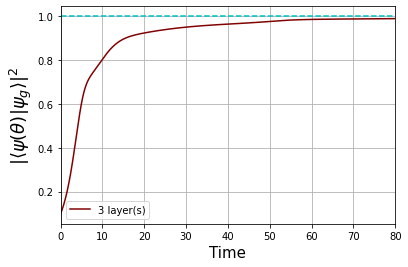

In [158]:
n = 3
colors = plt.cm.jet(np.linspace(0,1,n))

plt.plot(time_domain,expt_value[0], color = colors[2],label = str(2+1)+" layer(s)")
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,80)
#plt.ylim(0.99,1)

#plt.savefig("Imaginary_time_evolution_fidelity_over_layers_7qutrits_M=0.1.pdf")

(0.0, 20.0)

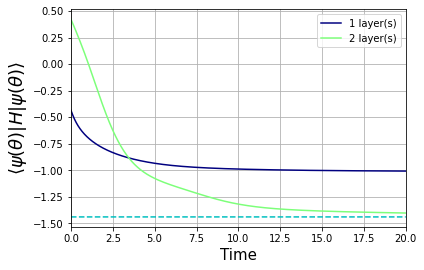

In [98]:
for kkk in range(3):
    plt.plot(time_domain,energyy[kkk], color = colors[kkk],label = str(kkk+1)+" layer(s)")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,20)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_over_layers_7qutrits_M=0.1.pdf")

###### import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [212]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [214]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [218]:
for i in range(coeff*N):
    print(Y[0][i])

0.37141536888406607
0.6602899660443315
0.11637371823579168
0.39901353290549235
0.9247979940631299
0.026453178512319396
0.4382807802429473
0.07025615093206115
0.3606296388374573
0.8138966259351307
0.9031720383192907
0.523454217057356
0.9272695715059814
0.9827474226150743
0.2639324508516817
0.41284186279042756
0.8757225556853009
0.523982524132141
0.9490899608210723
0.6202612047452045
0.19801202641088236
0.6716191124543176


(0.0, 10.0)

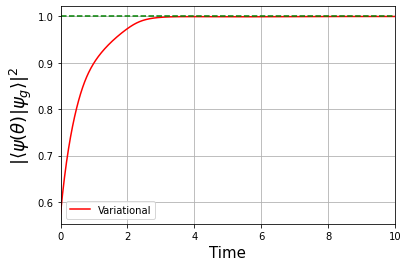

(0.0, 10.0)

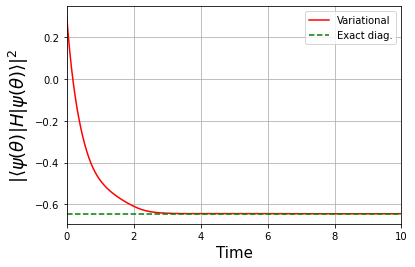

In [220]:
plt.plot(time_domain,energy, color = "red",label = "Variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="g", label = "Exact diag.")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_1.pdf")

In [221]:
print(expt_value_u[-1])

0.999481430342308


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
